In [1]:
# Check the data
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
station="28079004"

In [3]:
df = pd.read_csv(f"/home/sebas/data/air_qual_aemet/{station}.csv",sep=";")

In [4]:
df.head()

,DATE,AEMET.BLH,AEMET.SP,AEMET.T2M,AEMET.TP,AEMET.U10,AEMET.V10,AEMET.WS,AEMET.WD,MACC.NO2,MACC.O3,MACC.PM10,MACC.PM25,SPA.NO2,SPA.O3,SPA.PM10,SPA.PM25
0,2013-07-01 10:00:00,649.157471,94378.5000,296.492920,4.235165e-22,-2.145237,0.100364,2.147583,92.678598,34.911728,49.551208,14.674492,11.609944,57.0,NaN,NaN,NaN
1,2013-07-01 11:00:00,781.914062,94366.6250,298.389648,4.235165e-22,-1.874795,0.412883,1.919721,102.419892,37.657890,53.360588,15.406871,12.252560,57.0,NaN,NaN,NaN
2,2013-07-01 12:00:00,972.309570,94331.1250,300.313965,4.235165e-22,-1.585706,0.771409,1.763387,115.941839,26.125113,64.737213,15.268597,9.232553,45.0,NaN,NaN,NaN
3,2013-07-01 13:00:00,2179.478760,94291.6875,302.364014,4.235165e-22,-1.357002,1.302465,1.880923,133.825214,19.706379,73.538773,12.838573,8.626498,42.0,NaN,NaN,NaN
4,2013-07-01 14:00:00,3467.073242,94220.6875,304.050781,4.235165e-22,-0.867949,1.785319,1.985119,154.072887,20.176041,82.475800,13.182467,8.578526,30.0,NaN,NaN,NaN


In [5]:
# Limiting Date
df = df[df["DATE"]<"2020-01-01"]

In [6]:
tdf = df[["DATE","SPA.NO2"]].copy()
tdf.columns = ["DATE","NO2"]

1. Data partitioning
2. Addressing missing values
3. Log transformation
4. Apply STL Decomposition
5. Moving window transformation (For the relevant architectures)
6. Trend normalisation

In [7]:
tdf["NO2"]=np.log1p(tdf["NO2"])

In [8]:
tdf.head()

,DATE,NO2
0,2013-07-01 10:00:00,4.060443
1,2013-07-01 11:00:00,4.060443
2,2013-07-01 12:00:00,3.828641
3,2013-07-01 13:00:00,3.761200
4,2013-07-01 14:00:00,3.433987


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

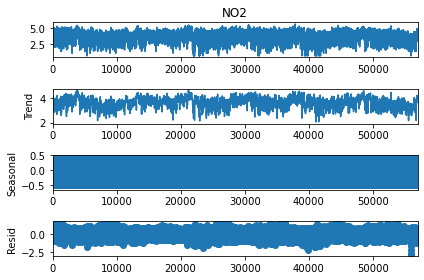

In [11]:
stl = seasonal_decomp = seasonal_decompose(tdf["NO2"], model="additive",period=24)
stl.plot();

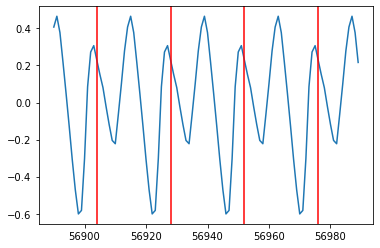

In [13]:
plt.plot(stl.seasonal[-100:])
for i in stl.seasonal[-100:].index:
    if i%(24)==0:
        plt.axvline(x=i,c="red")

In [14]:
tdf["NO2_noseason"]=tdf["NO2"]-stl.seasonal

In [15]:
tdf.head()

,DATE,NO2,NO2_noseason
0,2013-07-01 10:00:00,4.060443,3.832071
1,2013-07-01 11:00:00,4.060443,3.909515
2,2013-07-01 12:00:00,3.828641,3.748381
3,2013-07-01 13:00:00,3.761200,3.782789
4,2013-07-01 14:00:00,3.433987,3.552079


In [16]:
tdf["trend"]=stl.trend

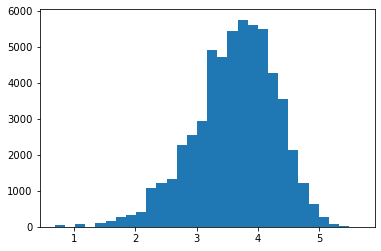

In [25]:
plt.hist(tdf["NO2"],bins=30);

In [27]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [28]:
torch.cuda.is_available()

True

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
horizon=13
tdf["trend_norm"]=tdf["trend"].shift(horizon)

# We remove the trend and keep past values
for h in reversed(np.arange(0,168*2)):
    if h>horizon:
        tdf[f"NO2 - {h}"]=(tdf["NO2"].shift(h)-tdf["trend_norm"]).copy()


tdf=tdf.dropna()

cols = tdf.columns[tdf.columns.str.contains("NO2 -")]
X = tdf[cols].copy()
y = tdf[["NO2"]].copy()

In [45]:
X_train.head()

,NO2 - 335,NO2 - 334,NO2 - 333,NO2 - 332,NO2 - 331,NO2 - 330,NO2 - 329,NO2 - 328,NO2 - 327,NO2 - 326,...,NO2 - 23,NO2 - 22,NO2 - 21,NO2 - 20,NO2 - 19,NO2 - 18,NO2 - 17,NO2 - 16,NO2 - 15,NO2 - 14
1675,-1.484863,-0.722723,-0.339730,-0.386250,-0.597559,-0.486334,-0.252719,-0.486334,-0.295279,-0.386250,...,0.282799,0.461048,0.440428,0.440428,0.306897,-0.029575,-0.295279,-0.597559,-0.597559,-0.658184
1676,-0.699635,-0.316643,-0.363163,-0.574472,-0.463247,-0.229632,-0.463247,-0.272191,-0.363163,-0.363163,...,0.484135,0.463515,0.463515,0.329984,-0.006488,-0.272191,-0.574472,-0.574472,-0.635097,-0.842736
1677,-0.304700,-0.351220,-0.562529,-0.451304,-0.217689,-0.451304,-0.260249,-0.351220,-0.351220,-0.217689,...,0.475458,0.475458,0.341927,0.005455,-0.260249,-0.562529,-0.562529,-0.623154,-0.830793,-0.562529
1678,-0.353856,-0.565166,-0.453940,-0.220325,-0.453940,-0.262885,-0.353856,-0.353856,-0.220325,-0.140282,...,0.472822,0.339291,0.002818,-0.262885,-0.565166,-0.565166,-0.625790,-0.833430,-0.565166,-0.262885
1679,-0.581412,-0.470187,-0.236572,-0.470187,-0.279131,-0.370103,-0.370103,-0.236572,-0.156529,0.140722,...,0.323044,-0.013428,-0.279131,-0.581412,-0.581412,-0.642037,-0.849676,-0.581412,-0.279131,0.051110


In [46]:
TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

X_train=X[X.index<=TRAIN_SPLIT].copy()
X_test=X[X.index>TRAIN_SPLIT].copy()
y_train = y[X.index<=TRAIN_SPLIT].copy()
y_test = y[X.index>TRAIN_SPLIT].copy()

In [48]:
from torch.utils.data import DataLoader, TensorDataset

X_train = torch.FloatTensor(X_train.values).to(device)
X_test = torch.FloatTensor(X_test.values).to(device)
y_train = torch.FloatTensor(y_train.values).to(device)
y_test= torch.FloatTensor(y_test.values).to(device)

In [51]:
import lightgbm as lgb

lgbmodel = lgb.LGBMRegressor(n_estimators=1600,
                                    random_state=2020,
                                  max_depth=6)

from sklearn.metrics import mean_squared_error
lgbmodel.fit(X_train.cpu(),y_train.cpu())
predictions = lgbmodel.predict(X_test.cpu())
np.sqrt(mean_squared_error(predictions,y_test.cpu()))

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.47617399633265695

In [99]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


In [109]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

fulls = len(X_train.cpu()[0])
mids = int(len(X_train.cpu()[0])/2)

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.whole = nn.Sequential(
        nn.Linear(fulls,2*fulls),
        nn.ReLU(),
        nn.LayerNorm(2*fulls),
        nn.Linear(2*fulls,mids),
        nn.ReLU(),
        nn.LayerNorm(mids),
        nn.Linear(mids,1)
        )

  def forward(self,x):
    x = self.whole(x)
    return x

net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0.00001)
#optimizer = COCOBBackprop(net.parameters())

loss_arr = []
val_loss_arr = []
epochs = 6

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, batch_size=256, shuffle=True)

for j in range(epochs):
  m_loss = []
  for i,batch in enumerate(train_loader):
    train_features, train_labels = batch
    y_hat = net.forward(train_features).to(device)
    loss = criterion(y_hat, train_labels)
    m_loss.append(loss.detach().cpu().numpy())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = net(X_test).cpu().reshape(-1).detach().numpy()
  loss_arr.append(np.mean(m_loss))
  val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))
  print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')

Epoch: 0 Loss: 98.58000946044922 Val Loss: 0.5143629312515259
Epoch: 1 Loss: 48.311012268066406 Val Loss: 0.5247993469238281
Epoch: 2 Loss: 41.34895706176758 Val Loss: 0.5203425288200378
Epoch: 3 Loss: 34.48879623413086 Val Loss: 0.5131049752235413
Epoch: 4 Loss: 29.288230895996094 Val Loss: 0.5140563249588013
Epoch: 5 Loss: 24.903411865234375 Val Loss: 0.5343739986419678


In [111]:
predictions = net(X_test).cpu().reshape(-1).detach().numpy()
np.sqrt(mean_squared_error(predictions,y_test.cpu()))

0.534374

In [137]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

n_channels = 10
k_size = 3
n_dil = 2

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.features = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n_channels, kernel_size=k_size, padding=1),
        nn.MaxPool1d(3),
        nn.ReLU(),
    )
    
    self.regressor = nn.Sequential(
        nn.LayerNorm(n_channels*107),
        nn.Linear(n_channels*107,200),
        nn.ReLU(),
        nn.LayerNorm(200),
        nn.Linear(200,1)
    )

  def forward(self,x):
    x = self.features(x)
    #print(x.shape)
    x = x.view(-1,n_channels*x.shape[2])
    return self.regressor(x)

In [177]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

n_channels = 10
k_size = 3
n_dil = 2

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__() 
    self.features = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=n_channels, kernel_size=k_size, padding=1),
        nn.MaxPool1d(2),
        nn.ReLU(),
        nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=k_size, padding=1),
        nn.MaxPool1d(2),
        nn.ReLU(),
    )
    
    self.regressor = nn.Sequential(
        nn.LayerNorm(n_channels*80),
        nn.Linear(n_channels*80,200),
        nn.ReLU(),
        nn.LayerNorm(200),
        nn.Linear(200,1)
    )

  def forward(self,x):
    x = self.features(x)
    #print(x.shape)
    x = x.view(-1,n_channels*x.shape[2])
    return self.regressor(x)

In [178]:
from torch.utils.data import DataLoader, TensorDataset

X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train_loader = DataLoader(train, batch_size=128, shuffle=True)

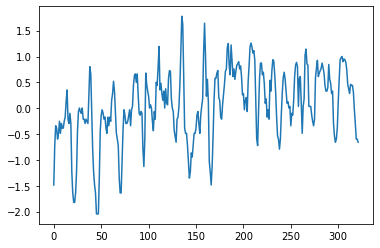

In [184]:
plt.plot(X_train_gf.cpu()[0][0])

In [179]:
net = Net() 
net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=0.00001)
optimizer = COCOBBackprop(net.parameters())

loss_arr = []
val_loss_arr = []
epochs = 6

for j in range(epochs):
    m_loss = []
    for i,batch in enumerate(train_loader):
      train_features, train_labels = batch
      y_hat = net.forward(train_features)
      loss = criterion(y_hat, train_labels)
      m_loss.append(loss.cpu().detach().numpy())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_arr.append(np.mean(m_loss))

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    predictions = net(X_test_gf).cpu().reshape(-1).detach().numpy()
    val_loss_arr.append(np.sqrt(mean_squared_error(predictions,y_test.cpu())))

    print(f'Epoch: {j} Loss: {np.mean(m_loss)} Val Loss: {np.sqrt(mean_squared_error(predictions,y_test.cpu()))}')


Epoch: 0 Loss: 42.8998908996582 Val Loss: 0.531817615032196
Epoch: 1 Loss: 26.897199630737305 Val Loss: 0.4874810576438904
Epoch: 2 Loss: 24.74496841430664 Val Loss: 0.47305676341056824
Epoch: 3 Loss: 22.74944496154785 Val Loss: 0.47848406434059143
Epoch: 4 Loss: 21.162534713745117 Val Loss: 0.5035784244537354
Epoch: 5 Loss: 19.994537353515625 Val Loss: 0.4994543492794037


In [180]:
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
predictions = net(X_test_gf).cpu().reshape(-1).detach().numpy()
np.sqrt(mean_squared_error(predictions,y_test.cpu()))

0.49945435